
## Project data science  : Clustering_ Prediction

Objectifs :
réaliser à partir d'un dataset les taches suivantes :

- Clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
- Prédiction des profils dont le métier n'est pas labellisé


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
    
    lien https://github.com/amineHY/prediction_employer_dataset/blob/master/script.py

In [223]:
#-LIBRARY CALL
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sb
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score 

#plt.style.use('ggplot')
%matplotlib notebook


## Exploratory Data Analysis

In [224]:
# Import du dataframe "data.csv"
df = pd.read_csv('data.csv')
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9582 entries, 0 to 9581
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Entreprise    9565 non-null   object
 1   Metier        9563 non-null   object
 2   Technologies  9582 non-null   object
 3   Diplome       9582 non-null   object
 4   Experience    9488 non-null   object
 5   Ville         9582 non-null   object
dtypes: object(6)
memory usage: 449.3+ KB


In [226]:
print("Cette base de données contient {} observations \n".format(df.shape[0]))
print("le nombre des valeus manquantes par features : \n{}".format(df.isna().sum()))


Cette base de données contient 9582 observations 

le nombre des valeus manquantes par features : 
Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64


#### Imputation des valeurs manquantes pour la variable "Experience" avec :
     la valeur médiane pour les data scientists
     la valeur moyenne pour les data engineers

In [227]:
df = pd.read_csv('data.csv')
def fill_na(df):
    df['Exp_float']=df['Experience'].str.replace(',','.').astype('float')
    median_Exp =df['Exp_float'].median()  
    mean_Exp =df['Exp_float'].mean()
    df.loc[(df.Metier=='Data scientist') & (df.Exp_float.isna()), 'Exp_float']=median_Exp
    df.loc[(df.Metier=='Data engineer') & (df.Exp_float.isna()), 'Exp_float']=mean_Exp
    
    return df
df=fill_na(df)
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_float
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris,1.0
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille,3.0
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes,3.0
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille,1.5
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux,2.0


In [228]:
df['Exp_float'].isna().sum()

42

In [229]:
# les années d'experienceen moyen des profils data scientist, lead data scientist et data engineer
exp=df.groupby('Metier').agg({'Exp_float':'mean'})

print('''la moyenne des années d'experiences pour les Data scientist est %.2f''' %exp.loc['Data scientist'][0] )
print('''la moyenne des années d'experiences pour les Lead data scientist est %.2f'''%exp.loc['Lead data scientist'][0]) 
print('''la moyenne des années d'experiences pour les Data engineer est %.2f'''   %exp.loc['Data engineer'][0]) 
print('''la moyenne des années d'experiences pour les Data architect est %.2f'''   %exp.loc['Data architecte'][0]) 


la moyenne des années d'experiences pour les Data scientist est 2.24
la moyenne des années d'experiences pour les Lead data scientist est 3.97
la moyenne des années d'experiences pour les Data engineer est 2.98
la moyenne des années d'experiences pour les Data architect est 3.00


<IPython.core.display.Javascript object>


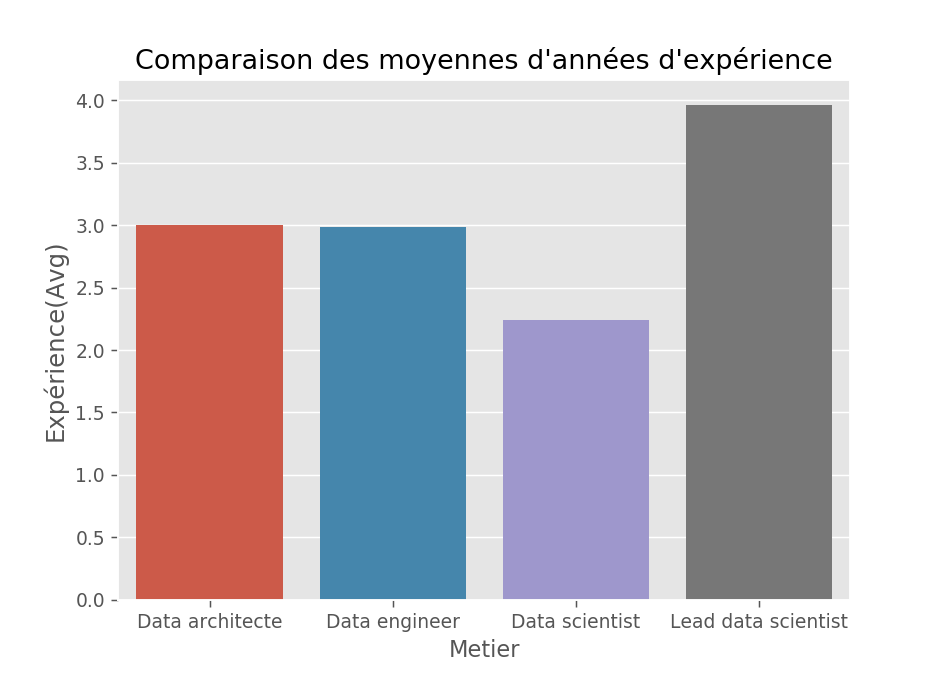

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

In [230]:
plt.figure(figsize=(7,5))
ax=sb.barplot(exp.index,exp['Exp_float'],)
ax.set_title('''Comparaison des moyennes d'années d'expérience''',)
ax.set_ylabel('Expérience(Avg)',fontsize=13)
plt.xticks(fontsize=10)

### Transformation dela variable continue 'Experience' en  variable catégorielle 'Exp_label':

In [231]:
# Transformation dela variable continue 'Experience' en  variable catégorielle 'Exp_label':
#avec 4 catégories (débutant, confirmé, avancé et expert)
df['Exp_label']=pd.cut(df.Exp_float,bins=4,labels=['débutant', 'confirmé', 'avancé' , 'expert'])
df.Exp_label.value_counts()

débutant    8438
confirmé     861
avancé       189
expert        52
Name: Exp_label, dtype: int64

### les 5 technologies les plus utilisées

<IPython.core.display.Javascript object>


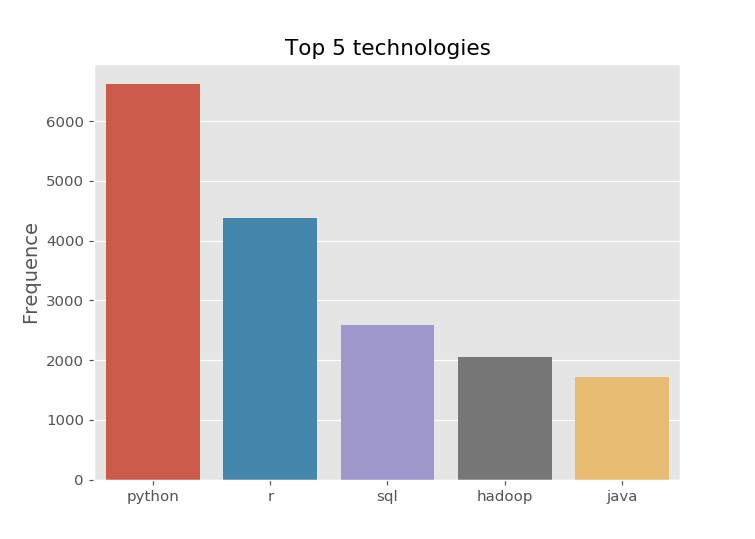

Text(0, 0.5, 'Frequence')

In [232]:
myserie= df.Technologies.str.lower()
mylist=[]
for i in range(df.shape[0]):
    [mylist.append(w) for w in df.Technologies[i].lower().split('/')] 
    
myS=pd.Series(mylist)
myS.replace({'hadoop(hdfs)':'hadoop','hdfs':'hadoop'},inplace=True)

fig,ax=plt.subplots(figsize=(7,5),dpi=80)
ax=sb.barplot(myS.value_counts()[0:5].index,myS.value_counts()[0:5].values)
ax.set_title('''Top 5 technologies''',)
ax.set_ylabel('Frequence',fontsize=13)


## Clustering non supervisée : 2 clusters

In [302]:
# Import du dataframe
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv('data.csv')

df=fill_na(df) #function above
df.dropna(inplace=True)
df=df.reset_index() 

df['Technologies'].replace(regex={'HADOOP\(HDFS\)': 'HADOOP', 'HDFS': 'HADOOP'}, inplace=True)
## Vectorisation des technologies dans df_vect_tech
Count_V = CountVectorizer(token_pattern=r"[^/]+")
vect_tech= Count_V.fit_transform(df.Technologies.values)
mydf=pd.DataFrame(vect_tech.toarray(),columns=Count_V.get_feature_names())

#Encoding of feature 'Diplome' & 'Metier'
LabEncod=LabelEncoder()
mydf['Diplome']=pd.Series(LabEncod.fit_transform(df.Diplome))
mydf['Metier']=pd.Series(LabEncod.fit_transform(df.Metier.astype('str')))

# Normalisation
scaler=MinMaxScaler()
mydf['Diplome']=pd.Series(np.squeeze(scaler.fit_transform((mydf.Diplome.values[:,np.newaxis]))))
mydf['Metier']=pd.Series(np.squeeze(scaler.fit_transform((mydf.Metier.values[:,np.newaxis]))))
mydf['Exp_float']=pd.Series(np.squeeze(scaler.fit_transform((df.Exp_float.values[:,np.newaxis]))))

<IPython.core.display.Javascript object>


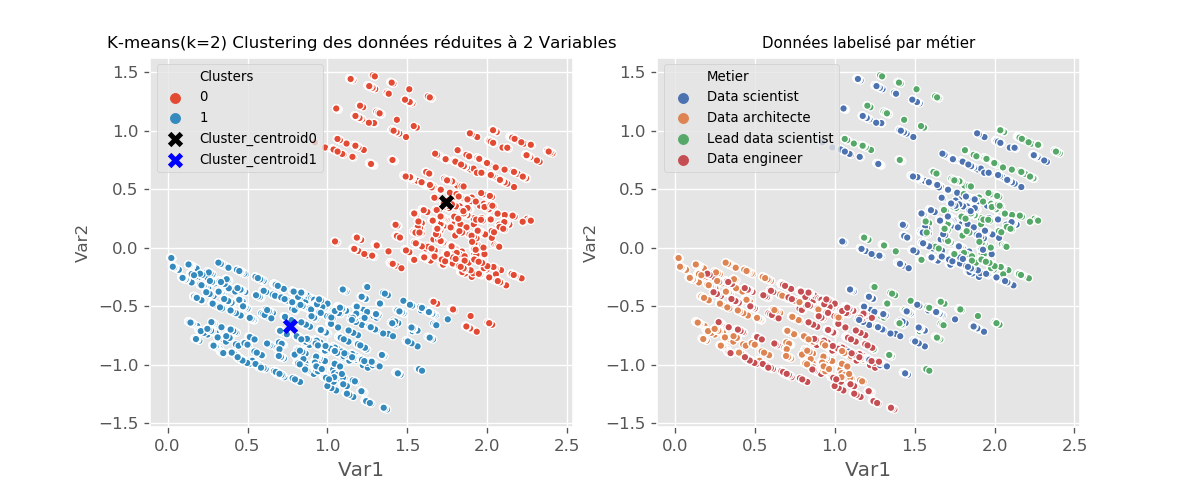

Text(0, 0.5, 'Var2')

In [303]:
## Reduction de dimension de mydf pour visualization des données sur un graphique 2D.
# Ici TruncatedSVD est utilisé à la place de PCA car mydf est une matrice creuse.

TSVD=TruncatedSVD(n_components=2).fit(mydf)
mydf_reduced=TSVD.transform(mydf)
result_df=pd.DataFrame(mydf_reduced,columns=['Var1','Var2'])


## Construction du modèle K-means à 2 clusters. 
kmns=KMeans(n_clusters=2,random_state=0)
kmns.fit_transform(mydf_reduced)

result_df['Clusters']=pd.Series(kmns.predict(mydf_reduced))
result_df['Metier']=df['Metier']


#====Clustering Visualization========

plt.figure(figsize=(10,4))
plt.subplot(121)
sb.scatterplot(result_df.Var1,result_df.Var2,hue=result_df.Clusters,s=20)
plt.scatter(kmns.cluster_centers_[0,0],kmns.cluster_centers_[0,1],c='k',label='Cluster_centroid0',marker='x',s=50,lw=3)
plt.scatter(kmns.cluster_centers_[1,0],kmns.cluster_centers_[1,1],c='b',label='Cluster_centroid1',marker='x',s=50,lw=3)
plt.legend(loc='upper left',fontsize=8)
plt.title('K-means(k=2) Clustering des données réduites à 2 Variables',fontsize=10)
plt.ylabel('Var2',fontsize=10)

plt.subplot(122)
ax2=sb.scatterplot(result_df.Var1,result_df.Var2,hue=result_df.Metier, palette="deep",s=20)
plt.title('Données labelisé par métier',fontsize=9)
plt.legend(fontsize=8)
plt.ylabel('Var2',fontsize=10)



    l'algorithme K-means(k=2) permet une separation des données en deux clusters bien distincts 0 et 1
    Le graphique labélisé par métier montre aussi une séparation en deux clusters des données. les deux clusters de métiers identifiées sont :
        - Data Scientists / Lead Data Scientist
        - Data Engineer / Data Architecte

    En comparant les deux graphiques les clusters définis par le modéle sont:
        - Cluster 0 = Data Scientists / Lead Data Scientist
        - Cluster 1 = Data Engineer / Data Architecte
    

### Evaluation des performances du modèle K_means
Vu que les clusters sont identifiés on peut calculer la performance du modèle en utilisant l'accuracy_score (label du modèle vs les profils métiers)



In [304]:
#Remplacement des métiers par des labels
labels=['Data scientist','Lead data scientist','Data engineer','Data architecte']
dict_labels=dict(zip(labels,[0,0,1,1]))
result_df['Metier']=result_df['Metier'].replace(dict_labels)


In [309]:
#Calcul de l'accuracy score
print('''l'accuracy du modèle K_means est {:.2f}'''.format(accuracy_score(result_df.Metier,result_df.Clusters)))
print('''l'inertie du modèle K_means est {:.2f}'''.format(kmns.inertia_))

l'accuracy du modèle K_means est 0.93
l'inertie du modèle K_means est 2464.37


    le score du modèle K_means a été évalué à 0.93 =>  93% des profils groupés dans les bons cluster (partageant les mêmes métiers)
    L'inertie du modèle est donnée pour information, plus l'inértie tends vers 0, plus le modèle est performant.

In [312]:
result_df

,Var1,Var2,Clusters,Metier
0,1.214108,-0.418585,1,0
1,0.825776,-0.877649,1,1
2,2.019295,0.367189,0,0
3,1.202083,-0.946236,1,0
4,1.748545,0.575486,0,0
...,...,...,...,...
9447,1.605506,-0.082242,0,0
9448,1.836096,0.710278,0,0
9449,1.175377,1.124999,0,0
9450,1.230726,-0.053455,0,0


### Prediction avec un autre modèle

In [327]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('data.csv')

df=fill_na(df) #function above
df.dropna(inplace=True)
df=df.reset_index() 

df['Technologies'].replace(regex={'HADOOP\(HDFS\)': 'HADOOP', 'HDFS': 'HADOOP'}, inplace=True)
## Vectorisation des technologies dans df_vect_tech
Count_V = CountVectorizer(token_pattern=r"[^/]+")
vect_tech= Count_V.fit_transform(df.Technologies.values)
mydf=pd.DataFrame(vect_tech.toarray(),columns=Count_V.get_feature_names())

#Encoding of feature 'Diplome' & 'Metier'
LabEncod=LabelEncoder()
mydf['Diplome']=pd.Series(LabEncod.fit_transform(df.Diplome))

# Normalisation
scaler=MinMaxScaler()
mydf['Diplome']=pd.Series(np.squeeze(scaler.fit_transform((mydf.Diplome.values[:,np.newaxis]))))
mydf['Exp_float']=pd.Series(np.squeeze(scaler.fit_transform((df.Exp_float.values[:,np.newaxis]))))
mydf['Metier']=df['Metier']

# Définition des sets de training et de test.
X=mydf.drop('Metier', axis=1)

y=mydf['Metier']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=0)


# Création du modèle Support Vector Machine
clf = svm.SVC(random_state=0).fit(X_train, y_train)
score=clf.score(X_test, y_test)  

print('La performance ou accuracy score de ce modèle est à %.2f \033[0m.' %score)

La performance ou accuracy score de ce modèle est à 0.87 .


    La performance de ce model a été évaluée par un accuracy score à 0.87. Ce score signifie que 87% des prédictions sont justes.

